In [18]:
import numpy as np
import os
from scipy.interpolate import interp1d
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy

# from palettable.colorbrewer.sequential import YlGnBu_9
# from palettable.scientific.sequential import Davos_8
# from palettable.scientific.sequential import Oslo_16
from numba import jit
nside = 4
from mpl_toolkits import mplot3d
from matplotlib import ticker

from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})

path=os.getcwd()

In [21]:
@jit(nopython=True)
def ThetaPhi(data):
    Tkf = data[:, 0]
    Pkf = data[:, 1]
    TXf = data[:, 2]
    PXf = data[:, 3]
    rX = data[:, 4]

    Theta = np.zeros(len(rX))
    Phi = np.zeros(len(rX))
    r_proj = np.max(rX)
    for i in range(len(rX)):
        xx = np.array([rX[i] * np.cos(PXf[i]) * np.sin(TXf[i]), rX[i] * np.sin(PXf[i]) * np.sin(TXf[i]), rX[i] * np.cos(TXf[i])])
        vv = np.array([ np.cos(Pkf[i]) * np.sin(Tkf[i]), np.sin(Pkf[i]) * np.sin(Tkf[i]), np.cos(Tkf[i])])
        tproj = -np.sum(xx*vv) + np.sqrt(4*np.sum(xx*vv)**2. - 4 * (rX[i]**2. - r_proj**2.))/2.
        Phi[i] = np.arctan2((vv[1] * tproj + xx[1]), (vv[0] * tproj + xx[0]))
        Theta[i] = np.arccos((vv[2] * tproj + xx[2]) / r_proj)
    return Theta,Phi

def ShowSkyMap(fileN, nside, thetaL=None):
    cmap = copy.copy(cm.get_cmap("viridis"))
    file_use = np.load(path + "/../src/results/"+fileN)
    Theta,Phi = ThetaPhi(file_use)
    rateT = np.sum(file_use[:, 5] * np.exp(-file_use[:, -1])
    pixel_indices = hp.ang2pix(nside, Theta, Phi)

    indxs = hp.nside2npix(nside)

    ratVs = np.zeros(hp.nside2npix(nside))
    ratVsTAU = np.zeros(hp.nside2npix(nside))
    nph = np.zeros(hp.nside2npix(nside))
    ratVsDisp1 = np.zeros(hp.nside2npix(nside))
    Tau = np.zeros(hp.nside2npix(nside))
    Disp = np.zeros(hp.nside2npix(nside))
    DispTAU = np.zeros(hp.nside2npix(nside))

    for i in range(indxs):
        
        rel_rows = file_use[pixel_indices == i]
        if len(rel_rows) == 0:
            ratVs[i] = 1e-10
            Disp[i] = 1e-10
            nph[i] = 0.0
        else:
            ratVs[i] = np.sum(rel_rows[:, 5] * np.exp(-rel_rows[:, -1])) / rateT  
        
            Disp[i] = np.sqrt(np.sum(rel_rows[:, 5] * np.exp(-rel_rows[:, -1]) * (rel_rows[:, 6] )**2) / np.sum(rel_rows[:, 5] * np.exp(-rel_rows[:, -1])))
            Tau[i] = np.sum(rel_rows[:, 5] * np.exp(-rel_rows[:, -1]) * rel_rows[:, -1]) / np.sum(rel_rows[:, 5] * np.exp(-rel_rows[:, -1]) ) 
    
    hp.mollview(np.log10(ratVs),   unit=r"$\log_{{10}}\left(R_{{i}}/R_{{\rm tot}} \right)$",xsize=2000, cmap=cmap)
    if thetaL != None:
        colorL = ["#73AB84", "#79C7C5", "#6B0504", "#241023", "#94849B", "#FFCAAF"]
        phiL = np.linspace(0, 2*np.pi, 100)
        for j in range(len(thetaL)):
            if len(thetaL) == 1:
                hp.visufunc.projplot(thetaL[j] * np.ones(len(phiL)), phiL, '#CE2D4F')
            else:
                hp.visufunc.projplot(thetaL[j] * np.ones(len(phiL)), phiL, colorL[j], lw=3)
            
    hp.mollview(np.log10(Disp) ,  unit=r"$\log_{{10}}\Delta B $", xsize=2000, cmap=cmap)
    hp.mollview(Tau,  unit=r"$\log_{{10}}\Delta B $", xsize=2000, cmap=cmap)
    
    
def TimePlotMulti(fileN, nside, thetaL, eps=0.1, binTot=50):
    file_use = np.load(path + "/../src/results/"+fileN)
    Theta, Phi = ThetaPhi(file_use)
    file_use[:,5] *= np.exp(-file_use[:,-1])
    rateT = np.sum(file_use[:, 5])
    fig, ax = plt.subplots(figsize=(10,6))
    colorL = ["#73AB84", "#79C7C5", "#6B0504", "#241023", "#94849B", "#FFCAAF"]
    
    for j in range(len(thetaL)):
        thetaC = thetaL[j]
        condition1 = Theta<thetaC+eps
        condition2 = Theta>thetaC-eps
        jointC = np.all(np.column_stack((condition1, condition2)), axis=1)
        file_short = file_use[jointC]
        Phi_short = Phi[jointC]
        Theta_short = Theta[jointC]

        vals, bins = np.histogram(Phi_short, bins=binTot)
        rateVs = np.zeros(binTot-1)
        for i in range(binTot-1):
            condition1_phi = Phi_short>bins[i]
            condition2_phi = Phi_short<bins[i+1]
            jointC_phi = np.all(np.column_stack((condition1_phi, condition2_phi)), axis=1)
            filePhi = file_short[jointC_phi]
            rateVs[i] = np.sum(filePhi[:,5]) / rateT

        
        for i in range(len(bins)):
            if bins[i] < 0:
                bins += np.pi
        plt.plot(bins[2:], rateVs, c=colorL[j], label=r"$\theta =${:.2f}".format(thetaC))

    plt.yscale("log")
    plt.xlim([bins[1] , bins[-1]])
    plt.xlabel('Time  [s]', fontsize=20);
    plt.ylabel('Flux [arb. units]', fontsize=20);
    plt.xticks([0, 1, 2, 3, 4, 5, 6], ('0', '', '2', '', '4', '', '6'))
    ax.tick_params(direction='in', length=8, width=1, labelsize=18)#, colors='r',grid_color='r', grid_alpha=0.5)
    ax.tick_params(which='minor', direction='in', length=3, width=1, labelsize=12)
    ax.legend(fontsize=16)
    
def TimeAnalysis(fileNList, legInfo, nside, eps=0.1, binTot=50):
    fig, ax = plt.subplots(figsize=(10,6))
    cnt = 0
    for fileN in fileNList:
        file_use = np.load("../src/results/"+fileN)
        Theta, Phi = ThetaPhi(file_use)
        file_use[:,5] *= np.exp(-file_use[:,-1])
        rateT = np.sum(file_use[:, 5])

        colorL = ["#73AB84", "#79C7C5", "#6B0504", "#241023", "#94849B", "#FFCAAF"]
        thetaL = np.linspace(0, np.pi, 200)
        FractionalTime = np.zeros(len(thetaL))
        for j in range(len(thetaL)):
            thetaC = thetaL[j]
            condition1 = Theta<thetaC+eps
            condition2 = Theta>thetaC-eps
            jointC = np.all(np.column_stack((condition1, condition2)), axis=1)
            file_short = file_use[jointC]
            Phi_short = Phi[jointC]
            Theta_short = Theta[jointC]
            num_pts = len(Phi_short)
            totbins = int(num_pts/20)
            if totbins >200:
                totbins = 200
            vals, bins = np.histogram(Phi_short, bins=totbins)
            rateVs = np.zeros(len(bins)-1)
            for i in range(len(rateVs)):
                condition1_phi = Phi_short>bins[i]
                condition2_phi = Phi_short<bins[i+1]
                jointC_phi = np.all(np.column_stack((condition1_phi, condition2_phi)), axis=1)
                
                filePhi = file_short[jointC_phi]
                rateVs[i] = np.sum(filePhi[:,5])

            rateTotTime = np.sum(rateVs)
            rateVs /= rateTotTime

            for i in range(len(bins)):
                if bins[i] < 0:
                    bins += np.pi
            tvals = (bins[:-1] + bins[1:])/2

            maxF = np.max(rateVs)
            minF = np.min(rateVs)
            fluxScan = np.logspace(np.log10(minF), np.log10(maxF), 100)
            fluxThres = np.zeros_like(fluxScan)
            for i in range(len(fluxScan)):
                fluxThres[i] = np.sum(rateVs[rateVs > fluxScan[i]]) 
            argHold = np.argmin(np.abs(fluxThres - 0.9))
            FractionalTime[j] = np.sum(rateVs > fluxScan[argHold]) / float(len(tvals))

        plt.plot(thetaL, FractionalTime, c=colorL[cnt], label=legInfo[cnt])
        cnt+=1

    plt.xlim([0, np.pi])
    plt.xlabel(r'$\theta$   [rad.]', fontsize=20);
    plt.ylabel(r'$\Delta t_{(F > 90\%)} / P_{NS}$', fontsize=20);
    ax.tick_params(direction='in', length=8, width=1, labelsize=18)
    ax.tick_params(which='minor', direction='in', length=3, width=1, labelsize=12)
    ax.legend(fontsize=16)

def make_histo_plots(fileN, nside, variables, varName='ThetaM'):
    if varName=='ThetaM':
        st_indx = fileN.find(varName) + len(varName) + 1
        end_indx = fileN.find('_rotPulsar')
        tag = r"$\theta_m$"
    elif varName == 'rotPulsar':
        st_indx = fileN.find(varName) + len(varName) + 1
        end_indx = fileN.find('_B0_')
        tag = r"$\omega_{NS}$"
    else:
        print('err...')
        return
    data = []
    for i in range(len(variables)):
        fileL = np.load("../src/results/"+fileN[:st_indx] +  variables[i] + fileN[end_indx:])
        Theta,Phi = ThetaPhi(fileL)
        fileL[:,5] *= np.exp(-fileL[:,-1])
        pixel_indices = hp.ang2pix(nside, Theta, Phi)
        indxs = hp.nside2npix(nside)
        Disp = []
        for j in range(indxs):
            rel_rows = fileL[pixel_indices == j]
            Disp.append(np.log10(np.sqrt(np.sum(rel_rows[:, 5] * (rel_rows[:, 6] )**2) / np.sum(rel_rows[:, 5]))))
        
        data.append(Disp)
    fig, ax = plt.subplots(figsize=(12,7))
    parts = ax.violinplot(data, showmeans=False, showmedians=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor('#CACECB')
        pc.set_edgecolor('black')
        pc.set_alpha(1)


    shiftX = 0.00043
    for i in range(len(variables)):

        quartile1, medians, quartile3 = np.percentile(data[i], [25, 50, 75])
    
        whiskers = np.array([adjacent_values(data[i], quartile1, quartile3) ])
        whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
        
        # for omega_NS
        shiftX += 0.00015
        ax.scatter(i+1 - shiftX, medians, marker='x', color='#840032', s=100, zorder=3)
        cQtil= '#0F6C95'
        ax.vlines(i+1, quartile1, quartile3, color=cQtil, linestyle='-', lw=2)
        epS = 0.05
        ax.hlines(quartile1, i+1 - epS, i+1 + epS, color=cQtil, linestyle='-', lw=2)
        ax.hlines(quartile3, i+1 - epS, i+1 + epS, color=cQtil, linestyle='-', lw=2)
    
    labels = []
    for i in range(len(variables)):
        labels.append(variables[i])
    set_axis_style(ax, labels, name=tag)
    ax.tick_params(direction='in', length=10, width=1, labelsize=16)
    ax.tick_params(which='minor', direction='in', length=6, width=1, labelsize=12)

    return

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def set_axis_style(ax, labels, name=""):
    ax.get_xaxis().set_tick_params(direction='in')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel(name, fontsize=22)
    ax.set_ylabel(r"$\log_{{10}} \Delta B$", fontsize=22)
    
    
def TimeLuminosity(fileNList, legInfo, eps=0.01, binTot=100):
    minS = 0.001
    fig, ax = plt.subplots(figsize=(10,6))
    cnt = 0
    for fileN in fileNList:
        #print(fileN)
        file_use = np.load("../src/results/"+fileN)
        Theta, Phi = ThetaPhi(file_use)
        file_use[:,5] *= np.exp(-file_use[:,-1])
        
        tag1 = fileN.find('rotPulsar_')
        tag2 = fileN.find('_B0_')
        period = 2*np.pi / float(fileN[tag1+len('rotPulsar_'):tag2])
        
        tag1 = fileN.find('_MassAx_')
        tag2 = fileN.find('_AxionG_')
        mass = float(fileN[tag1+len('_MassAx_'):tag2])

        colorL = ["#73AB84", "#79C7C5", "#6B0504", "#94849B", "#FFCAAF"]
        thetaL = np.linspace(minS, np.pi-minS, binTot)
        Lum = np.zeros(len(thetaL))
        Hookfactor = 2.78e28 # eV / s, defined in terms of g/1e-12 GeV-1, ma/1e-6 eV, B0/1e14 G, omega_ns / 1, rho = 0.3 Gev/cm^3
        
        B = 1e14
        Hookfactor *= (mass / 1e-6)**(5./3.) * (B/1e14)**(2./3.) * (1/(2*np.pi/period))**(4./3.)
        HLum = np.zeros(len(thetaL))
        vel_list = np.zeros(len(thetaL))
        AngFactor = np.zeros(len(thetaL))
        for j in range(len(thetaL)):
            thetaC = thetaL[j]
            condition1 = Theta<thetaC+eps
            condition2 = Theta>thetaC-eps
            jointC = np.all(np.column_stack((condition1, condition2)), axis=1)
            file_short = file_use[jointC]
            HLum[j] = Hookfactor * 2*np.pi * (1+3*np.cos(thetaL[j])**2.) / np.abs(3*np.cos(thetaL[j])**2 - 1)**(4./3.)  / period
            
            Lum[j] =  np.sum(file_short[:,5]) * mass / (2 * np.sin(thetaL[j]) * 2 * np.sin(eps)) / period  # eV / s
            
            r_hold = np.sqrt(np.sum(file_use[jointC,8:11]**2., axis=1))
            vel_list[j] = np.median(np.sqrt(2 * 132698000000.0  / r_hold) / 2.998e5)
    
    
   
        
            mDR = np.cos(thetaL[j]) 
            timeHold = (3 * mDR**2. + 1) / np.abs(3*np.cos(thetaL[j])*mDR - 1.0)**(4./3.) 
            AngFactor[j] = 2* np.pi * timeHold / vel_list[j] / period

        
        
        dPHook = Hookfactor * AngFactor

            
        print('Median Luminosity / Marginal: ',  np.trapz(Lum * np.sin(thetaL), thetaL))
        print('Marginal Luminosity / Bens: ', np.trapz(Lum * np.sin(thetaL), thetaL) / np.trapz(dPHook * np.sin(thetaL), thetaL))
        plt.plot(thetaL, Lum, c=colorL[cnt], label=legInfo[cnt])
        cnt+=1
    plt.plot(thetaL, dPHook, c='k', ls='--', label=r'Hook et al '+ legInfo[-1])
    plt.yscale("log")
    plt.xlim([0.0, np.pi ])
    plt.ylim([1e25, 2e33])
    plt.xlabel(r'$\theta$ \hspace{.5cm} [rad.]', fontsize=24);
    plt.ylabel(r'$dP / d\theta$ \hspace{.5cm} [eV / s]', fontsize=24);
    #plt.xticks([0, 1, 2, 3, 4, 5, 6], ('0', '', '2', '', '4', '', '6'))
    ax.tick_params(direction='in', length=8, width=1, labelsize=18)#, colors='r',grid_color='r', grid_alpha=0.5)
    ax.tick_params(which='minor', direction='in', length=4, width=1, labelsize=12)
    ax.legend(loc='lower right',fontsize=14)

    return


In [ ]:
fileN="Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.2_rotPulsar_1.0_B0_5.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
nside=32
ShowSkyMap(fileN, nside)

In [ ]:
fileN="Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.2_rotPulsar_1.0_B0_5.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
nside=32
ShowSkyMap(fileN, nside, thetaL=[1])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


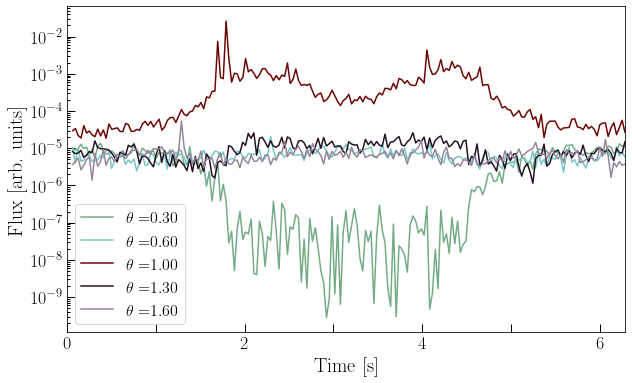

In [14]:
fileN="Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
TimePlotMulti(fileN, 16,thetaL=[0.3, 0.6, 1.0, 1.3, 1.6], eps=0.03, binTot=200)

<ipython-input-18-488ed105b22a>:144: RuntimeWarning: divide by zero encountered in log10
  fluxScan = np.logspace(np.log10(minF), np.log10(maxF), 100)
/Users/samuelwitte/anaconda3/lib/python3.8/site-packages/numpy/core/function_base.py:144: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/samuelwitte/anaconda3/lib/python3.8/site-packages/numpy/core/function_base.py:154: RuntimeWarning: invalid value encountered in add
  y += start


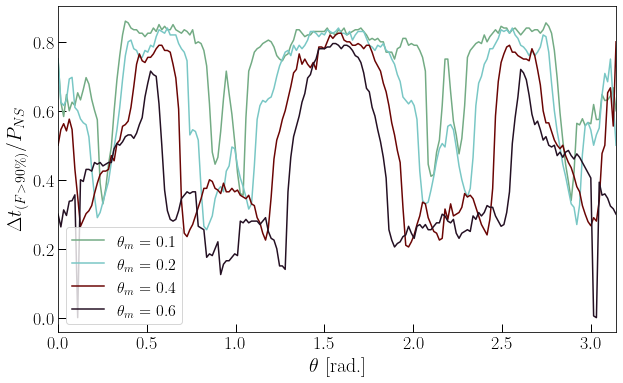

In [21]:
fileN1 = "Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.1_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
fileN2 = "Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
fileN3 = "Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.4_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
fileN4 = "Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.6_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
TimeAnalysis([fileN1,fileN2,fileN3,fileN4], [r"$\theta_m = 0.1$", r"$\theta_m = 0.2$", r"$\theta_m = 0.4$", r"$\theta_m = 0.6$"], 2, eps=0.05, binTot=30)

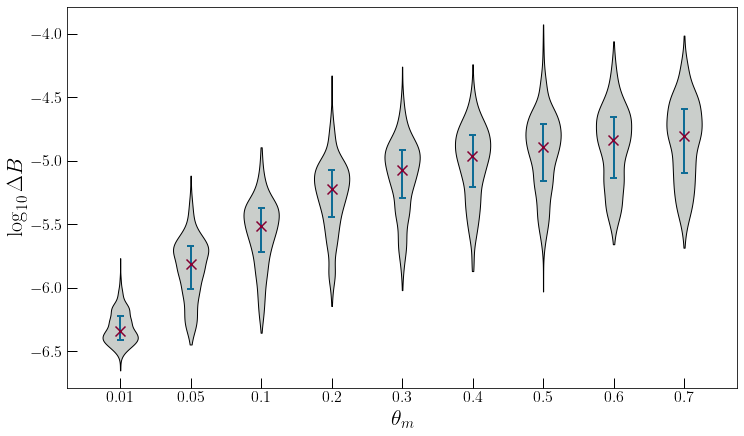

In [19]:
fileN="Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.7_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
nside=8
variables=['0.01', '0.05', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7']
make_histo_plots(fileN, nside, variables, varName='ThetaM')

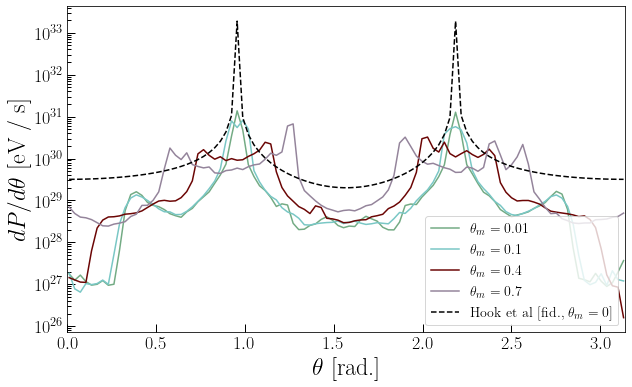

In [26]:
fileN1 = "Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.01_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
fileN2 = "Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.1_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
fileN3 = "Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.4_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
fileN4 = "Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.7_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
fileList = [fileN1,fileN2, fileN3, fileN4]
labels= [r"$\theta_m = 0.01$",r"$\theta_m = 0.1$",r"$\theta_m = 0.4$",r"$\theta_m = 0.7$", r"[fid., $\theta_m = 0$]"]
TimeLuminosity(fileList, labels, eps=0.02, binTot=100)

In [29]:
import matplotlib
matplotlib.use('pdf')
def make_CS_with_photons(fileN, nside, nph=1, t_indx=800):
    file_use = np.load(path + "/../src/results/"+fileN)
    file_use[:, 5] *= np.exp(-file_use[:,-1])
    indxs = hp.nside2npix(nside)
    color=cm.RdBu(np.linspace(0,1,indxs))
    color_arr = []
    init_cords = []
    num_pts = 100000

    Theta,Phi = ThetaPhi(file_use)
    rateT = np.sum(file_use[:, 5])
    pixel_indices = hp.ang2pix(nside, Theta, Phi)
    indxs = hp.nside2npix(nside)

    for i in range(indxs):
        rel_rows = file_use[pixel_indices == i]
        hold_arr = rel_rows[np.argsort(rel_rows[:, 5])]
        if len(hold_arr[:,0]) > num_pts:
            largest_rat = hold_arr[:num_pts]
            run_pts = num_pts
        else:
            largest_rat = hold_arr
            run_pts = len(hold_arr[:,0])
        for j in range(run_pts):
            init_cords.append(rel_rows[j, 8:11])

            color_arr.append(color[i])

    init_cords = np.asarray(init_cords)
    color_arr = np.asarray(color_arr)
    
    photonsX = np.zeros(nph, dtype=object)
    for i in range(nph):
        photonsX[i] = np.load(path + "/Sample_Trajs/TrajSamp_{:.0f}.npz".format(i+1))

    fig, ax = plt.subplots(figsize=(20,30))
    ax = plt.axes(projection='3d')
    plt.axis('off')
    ax.scatter(init_cords[:,0], init_cords[:,1], init_cords[:,2], color=color_arr, alpha=1)

    max_dist = 0
    for jj in range(nph):
        ax.scatter(photonsX[jj][0, :t_indx], photonsX[jj][1, :t_indx], photonsX[jj][2, :t_indx], '-', color='black',  alpha=1, s=1e-1, linewidths=1)
        dist_h = np.sqrt(np.sum(photonsX[jj][:3, t_indx-1]**2.))
        if dist_h > max_dist:
            max_dist = dist_h
            
    thetaL = np.linspace(0,np.pi, 500)
    phiL = np.linspace(np.pi/2, 3*np.pi/2, 1000)
    coord = []
    color_hold = []
    for i in range(len(thetaL)):
        for j in range(len(phiL)):
            iH = hp.ang2pix(nside, thetaL[i], phiL[j])
            color_hold.append(color[iH])
            coord.append([max_dist * np.sin(thetaL[i]) * np.cos(phiL[j]), max_dist * np.sin(thetaL[i]) * np.sin(phiL[j]), max_dist * np.cos(thetaL[i])])
    coord = np.asarray(coord)
    color_hold = np.asarray(color_hold)

    ax.scatter(coord[:,0], coord[:,1], coord[:,2], c=color_hold, alpha=.009, cmap=cm.RdBu)
    ax.set_box_aspect((np.ptp(coord[:,0]), np.ptp(coord[:,1]), np.ptp(coord[:,2])))
    
    ax.view_init(elev=10, azim=0)

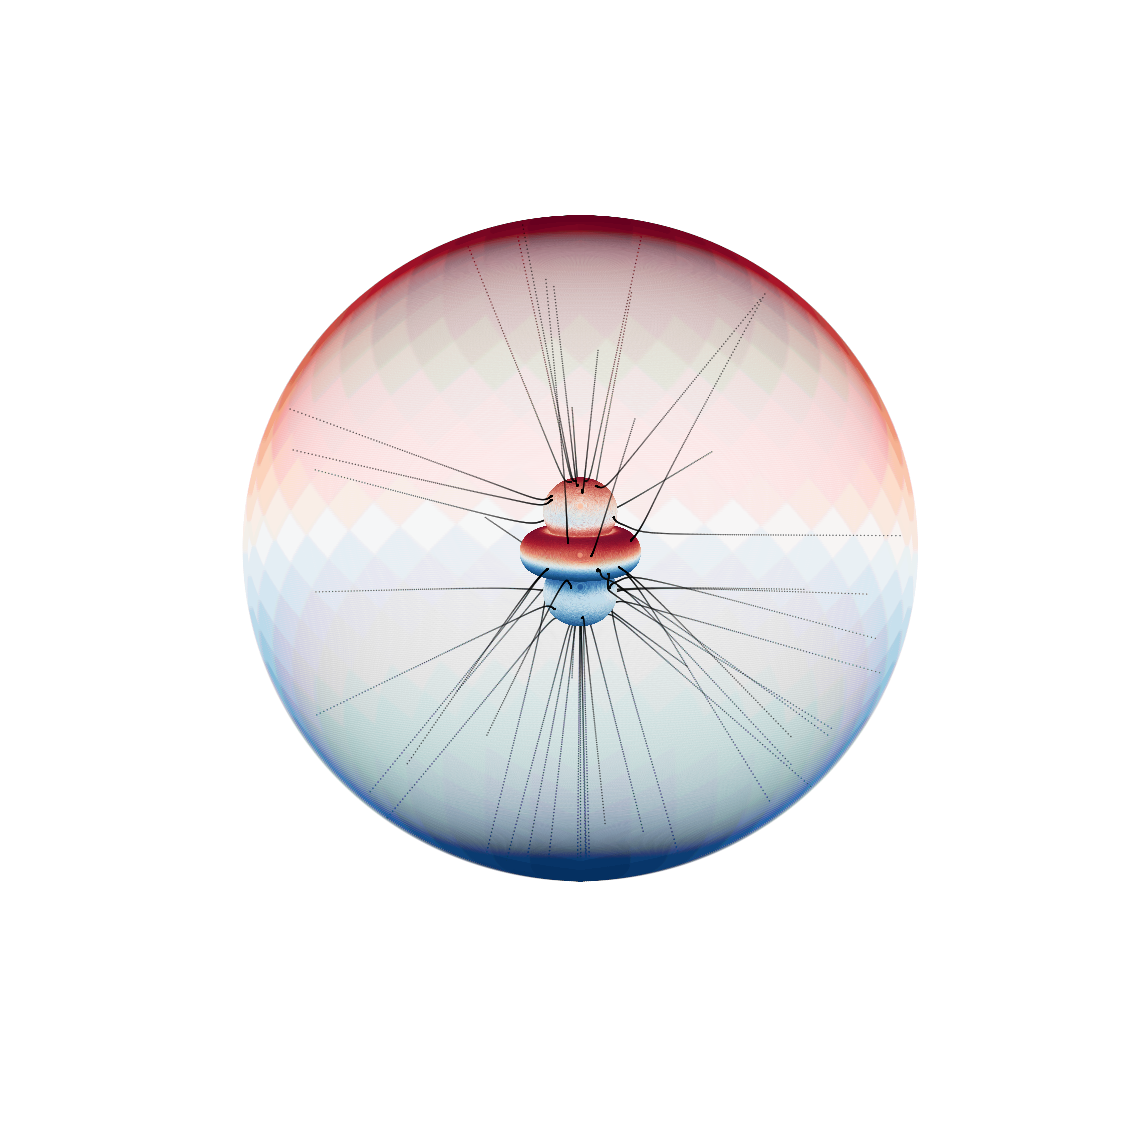

In [30]:
fileN = "Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
make_CS_with_photons(fileN, 8, nph=50, t_indx=700)